<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task15(Pro)_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Кластеризация базы hh

#Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras import utils #for OHE
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from keras.preprocessing.text import Tokenizer, text_to_word_sequence, tokenizer_from_json
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import DB

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/база hh кластеризация по резюме.csv")
print(df.shape)
df.head()

(7778, 10)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последеняя/нынешняя должность,Образование и ВУЗ,Авто
0,"Женщина, 21 год, родилась 26 марта 1998",30 000 руб.,Специалист по поддержке пользователей,"Тимашевск, готова к переезду, готова к команди...","проектная работа, стажировка, частичная занят...","удаленная работа, гибкий график, полный день,...",Опыт работы 4 месяца\n\nОктябрь 2018 — январь ...,Медицинская сестра палатная,"Среднее специальное образование 2018 ГБПОУ ""Ей...",NaN
1,"Мужчина, 23 года, родился 17 января 1996",NaN,Программист,"Воронеж, не готов к переезду, не готов к коман...",полная занятость,полный день,Опыт работы 2 года 9 месяцев\n\nОктябрь 2016 —...,Сервисный инженер,Образование Среднее специальное образование,Имеется собственный автомобиль
2,Мужчина,NaN,Веб-программист,"Мытищи, не готов к переезду, не готов к команд...",полная занятость,полный день,Опыт работы 3 года 1 месяц\n\nЯнварь 2019 — ию...,Web-разработчик,Неоконченное высшее образование 2019 Московски...,NaN
3,"Мужчина, 35 лет, родился 24 октября 1983",50 000 руб.,Аналитик-консультант 1С,"Нижний Новгород, не готов к переезду, готов к ...",полная занятость,"гибкий график, полный день, сменный график",Опыт работы 13 лет 1 месяц\n\nМарт 2016 — по н...,Специалист по планированию производства,Высшее образование 2006 Волго-Вятская академия...,NaN
4,"Мужчина, 28 лет, родился 3 ноября 1990",45 000 руб.,Электромонтер связи,"Москва, м. Отрадное, готов к переезду, готов к...",полная занятость,полный день,Опыт работы 7 лет 8 месяцев\n\nДекабрь 2018 — ...,Инженер,Среднее специальное образование 2011 Колледж с...,NaN


#Parsing the DB

In [ ]:
#arg - each row in db
def getParameterSex(arg):
  out = 0            # По умолчанию женский пол
  if(arg[0] == "M" or arg[0] == "М"): # Если в arg[0] буква М, то в выход записываем 1
    out = 1
  return out         # Возвращаем числовое представление пола

def getParameterAge(arg):
  found=re.search(r"(\d\d)", arg)
  if found:
    out=found.group(0)
  else:
    out=0
  return out      

def getParameterAge2(arg):
  out = 0                                             # По умолчанию в выход записываем 0
  if (len(arg) > 7):                                  # Если в строке больше 7 символов (значит имеется информация о возрасте)
    ageStr = arg[len(arg)-4:len(arg)]                 # Получаем последние 4 символа во входной строке (год рождения)
    out = 2022 - int(ageStr)                          # Получаем возраст   
  return out                                          # Возвращаем возраст     

def getParameterAgeVect(arg):
  out = getParameterAge2(arg) # Получаем возраст по году рождения 
  outClass = 0                # По умолчанию в out записываем 0

  if (out > 18): # Если старше 19 лет, изменяем out на 1
    outClass = 1
  if (out > 23): # Если старше 23 лет, изменяем out на 2
    outClass = 2
  if (out > 28): # Если старше 28 лет, изменяем out на 3
    outClass = 3
  if (out > 33): # Если старше 33 лет, изменяем out на 4
    outClass = 4
  if (out > 38): # Если старше 38 лет, изменяем out на 5
    outClass = 5
  if (out > 43): # Если старше 43 лет, изменяем out на 6
    outClass = 6
  if (out > 48): # Если старше 48 лет, изменяем out на 7
    outClass = 7
  if (out > 53): # Если старше 53 лет, изменяем out на 8
    outClass = 8 
  if (out > 58): # Если старше 58 лет, изменяем out на 9
    outClass = 9 
  if (out > 63): # Если старше 63 лет, изменяем out на 10
    outClass = 10  
  return list(utils.to_categorical(outClass, 11).astype('int')) # Возвращаем OHE представление возраста по 11 классам     

def getParameterSalary(arg):
  if arg!=arg:
    out=-1
  elif re.search(r"руб", arg, flags=re.I) or re.search(r"RUB", arg, flags=re.I) or re.search(r"KZT", arg, flags=re.I):
     out=int(re.search(r"\d+\s*\d*", arg).group(0).replace('\xa0',''))
  elif re.search(r"USD", arg, flags=re.I):
    out=int(re.search(r"\d+\s*\d*", arg).group(0).replace('\xa0',''))
    out=out*75
  elif re.search(r"EUR", arg, flags=re.I):
    out=int(re.search(r"\d+\s*\d*", arg).group(0).replace('\xa0',''))
    out=out*84
  return out    

def getParameterSity(arg):
  out = [0, 0, 0, 1]         # По умолчанию город проживания не Москва, не Санкт-Петербург и не миллионник  
  index = 0                  # В индекс запишем позицию символа первой запятой во входной строке
  while (arg[index] != ","): # Пробегаем по всем символам входной строки, пока не встретим запятую
    index += 1               # Увеличиваем index на 1  
  sityStr = arg[:index]      # Записываем в sityStr город прживания    
  millionSities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград" # Строка, содержащая города милионники  
  if (sityStr == "Москва"):  # Если город проживания - Москва
    out[0] = 1               # Записываем в 0-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию
  if (sityStr == "Санкт-Петербург"): # Если город проживания - Санкт-Петербург
    out[1] = 1               # Записываем в 1-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию
  if (sityStr in millionSities): # Если город проживания один из городов милионников
    out[2] = 1               # Записываем во 2-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию  
  return out                 # Возвращаем OHE-представление города проживания по 4 классам

def getParameterEmployment(arg):
  out = [0, 0, 0, 0]                                              # По умолчанию желаемый тип занятости не указан  
  if ("стажировка" in arg) or ("work placement" in arg):          # Если во входной строке имеется пункт: стажировка
    out[0] = 1                                                    # Записываем в 0-позицию 1
  if ("частичная занятость" in arg) or ("part time" in arg):      # Если во входной строке имеется пункт: частичная занятость
    out[1] = 1                                                    # Записываем в 1-позицию 1
  if ("проектная работа" in arg) or ("project work" in arg):      # Если во входной строке имеется пункт: проектная работа
    out[2] = 1                                                    # Записываем в 2-позицию 1
  if ("полная занятость" in arg) or ("full time" in arg):         # Если во входной строке имеется пункт: полная занятость
    out[3] = 1                                                    # Записываем в 3-позицию 1
  return out                                                      # Возвращаем список желаемых типов занятости

def getParameterSchedule(arg):
  out = [0, 0, 0, 0]                                              # По умолчанию желаемый график не указан  
  if ("гибкий график" in arg) or ("flexible schedule" in arg):    # Если во входной строке имеется пункт: гибкий график
    out[0] = 1                                                    # Записываем в 0-позицию 1
  if ("полный день" in arg) or ("full day" in arg):               # Если во входной строке имеется пункт: полный день
    out[1] = 1                                                    # Записываем в 1-позицию 1
  if ("сменный график" in arg) or ("shift schedule" in arg):      # Если во входной строке имеется пункт: сменный график
    out[2] = 1                                                    # Записываем в 2-позицию 1
  if ("удаленная работа" in arg) or ("remote working" in arg):    # Если во входной строке имеется пункт: удаленная работа
    out[3] = 1                                                    # Записываем в 3-позицию 1  
  return out                                                      # Возвращаем список желаемых графиков работы

def getParameterEducation(arg):
  out = [0, 0, 0, 0]                                                # По умолчанию образование не указано  
  if ("Высшее" in arg) or ("Higher education" in arg):              # Если во входной строке имеется пункт: Высшее
    out[0] = 1                                                      # Записываем в 0-позицию 1                    
  if ("Среднее специальное" in arg):                                # Если во входной строке имеется пункт: Среднее специальное
    out[1] = 1                                                      # Записываем в 1-позицию 1
  if ("Неоконченное высшее" in arg):                                # Если во входной строке имеется пункт: Неоконченное высшее
    out[2] = 1                                                      # Записываем в 2-позицию 1
  if ("Среднее образование" in arg):                                # Если во входной строке имеется пункт: Среднее образование
    out[3] = 1                                                      # Записываем в 3-позицию 1  
  return out                                                        # Возвращаем список с данными об образовании

def getParameterExperience(arg):
  years=0
  if re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]год)", arg):
    years=re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]год)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]лет)", arg):
    years=re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]лет)", arg).group(0)

  months=0
  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]год[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]год[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]год[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]год[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]года[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]года[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]года[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]года[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]лет[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\s*]лет[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]лет[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*][\d*][\d*][\s*]лет[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  if re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]месяц)", arg):
    months=re.search(r"(?<=^Опыт[\s*]работы[\s*])\d*(?=[\s*]месяц)", arg).group(0)

  out=12*int(years) + int(months)
  return out

def getParameterExperienceVector(arg):
  out = getParameterExperience(arg) # Получаем данные об опыте работы
  outClass = 0    # По умолчанию в out записываем 0
  if (out > 6):   # Если опыт работы составляет более 6 месяцев, изменяем out на 1
    outClass = 1
  if (out > 12):  # Если опыт работы составляет более 12 месяцев, изменяем out на 2
    outClass = 2 
  if (out > 24):  # Если опыт работы составляет более 24 месяцев, изменяем out на 3
    outClass = 3
  if (out > 36):  # Если опыт работы составляет более 36 месяцев, изменяем out на 4
    outClass = 4
  if (out > 60):  # Если опыт работы составляет более 60 месяцев, изменяем out на 5
    outClass = 5
  if (out > 96):  # Если опыт работы составляет более 96 месяцев, изменяем out на 6
    outClass = 6
  if (out > 120): # Если опыт работы составляет более 120 месяцев, изменяем out на 7
    outClass = 7
  if (out > 156): # Если опыт работы составляет более 156 месяцев, изменяем out на 8
    outClass = 8
  if (out > 192): # Если опыт работы составляет более 192 месяцев, изменяем out на 9
    outClass = 9 
  if (out > 240): # Если опыт работы составляет более 240 месяцев, изменяем out на 10
    outClass = 10  
  return list(utils.to_categorical(outClass, 11).astype('int')) # Возвращаем OHE-представление данных об опыте работы по 11 классам

In [ ]:
sexes=[]
ages=[]
ages01=[]
salaries=[]
cities=[]
employments=[]
schedules=[]
educations=[]
experiences=[]
experiences01=[]
for index, col in df.iterrows():
  arg_sex_age=col[0]
  arg_salary=col[1]
  arg_city=col[3]
  arg_employment=col[4]
  arg_schedule=col[5]
  arg_education=col[8]
  arg_experience=col[6]
  sexes.append(getParameterSex(arg_sex_age))
  ages.append(getParameterAge2(arg_sex_age))
  ages01.append(getParameterAgeVect(arg_sex_age))
  salaries.append(getParameterSalary(arg_salary))
  cities.append(getParameterSity(arg_city))
  employments.append(getParameterEmployment(arg_employment))
  schedules.append(getParameterSchedule(arg_schedule))
  educations.append(getParameterEducation(arg_education))
  experiences.append(getParameterExperience(arg_experience))
  experiences01.append(getParameterExperienceVector(arg_experience))
df['Sex']=sexes
df['Age']=ages
df['Age01']=ages01
df['Salary']=salaries
df['City']=cities
df['Employment']=employments
df['Schedule']=schedules
df['Education']=educations
df['Experience']=experiences
df['Experience01']=experiences01
print(df['Sex'].value_counts())
print('\n')
print(df['Age'].value_counts())
print('\n')
print(df['Age01'].value_counts())
print('\n')
print(df['Salary'].value_counts())
print('\n')
print(df['City'].value_counts())
print('\n')
print(df['Employment'].value_counts())
print('\n')
print(df['Schedule'].value_counts())
print('\n')
print(df['Education'].value_counts())
print('\n')
print(df['Experience'].value_counts())
print('\n')
print(df['Experience01'].value_counts())

1    5983
0    1795
Name: Sex, dtype: int64


34    431
36    412
35    400
32    395
33    389
31    378
30    364
37    339
38    326
28    307
29    304
0     292
39    290
40    254
27    251
26    241
41    220
43    193
42    190
45    158
44    150
25    149
24    127
47    127
46    120
49     99
51     77
48     77
50     70
53     64
52     63
23     62
56     53
55     47
57     46
54     38
22     37
60     29
58     28
62     25
59     25
61     23
63     22
65     17
64     15
21     15
68      7
66      7
70      4
67      4
18      3
20      2
71      2
73      2
74      2
19      2
72      1
76      1
81      1
77      1
Name: Age, dtype: int64


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    1908
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]    1830
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]    1147
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]    1075
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]     632
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]     373
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     295
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 

In [ ]:
#pd.set_option('display.max_rows', 8000)
df.head()

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последеняя/нынешняя должность,Образование и ВУЗ,Авто,Sex,Age,Age01,Salary,City,Employment,Schedule,Education,Experience,Experience01
0,"Женщина, 21 год, родилась 26 марта 1998",30 000 руб.,Специалист по поддержке пользователей,"Тимашевск, готова к переезду, готова к команди...","проектная работа, стажировка, частичная занят...","удаленная работа, гибкий график, полный день,...",Опыт работы 4 месяца\n\nОктябрь 2018 — январь ...,Медицинская сестра палатная,"Среднее специальное образование 2018 ГБПОУ ""Ей...",NaN,0,24,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",30000,"[0, 0, 0, 1]","[1, 1, 1, 1]","[1, 1, 1, 1]","[0, 1, 0, 0]",4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Мужчина, 23 года, родился 17 января 1996",NaN,Программист,"Воронеж, не готов к переезду, не готов к коман...",полная занятость,полный день,Опыт работы 2 года 9 месяцев\n\nОктябрь 2016 —...,Сервисный инженер,Образование Среднее специальное образование,Имеется собственный автомобиль,1,26,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",-1,"[0, 0, 1, 0]","[0, 0, 0, 1]","[0, 1, 0, 0]","[0, 1, 0, 0]",33,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,Мужчина,NaN,Веб-программист,"Мытищи, не готов к переезду, не готов к команд...",полная занятость,полный день,Опыт работы 3 года 1 месяц\n\nЯнварь 2019 — ию...,Web-разработчик,Неоконченное высшее образование 2019 Московски...,NaN,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1,"[0, 0, 0, 1]","[0, 0, 0, 1]","[0, 1, 0, 0]","[0, 0, 1, 0]",37,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,"Мужчина, 35 лет, родился 24 октября 1983",50 000 руб.,Аналитик-консультант 1С,"Нижний Новгород, не готов к переезду, готов к ...",полная занятость,"гибкий график, полный день, сменный график",Опыт работы 13 лет 1 месяц\n\nМарт 2016 — по н...,Специалист по планированию производства,Высшее образование 2006 Волго-Вятская академия...,NaN,1,39,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",50000,"[0, 0, 1, 0]","[0, 0, 0, 1]","[1, 1, 1, 0]","[1, 0, 0, 0]",157,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,"Мужчина, 28 лет, родился 3 ноября 1990",45 000 руб.,Электромонтер связи,"Москва, м. Отрадное, готов к переезду, готов к...",полная занятость,полный день,Опыт работы 7 лет 8 месяцев\n\nДекабрь 2018 — ...,Инженер,Среднее специальное образование 2011 Колледж с...,NaN,1,32,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",45000,"[1, 0, 0, 0]","[0, 0, 0, 1]","[0, 1, 0, 0]","[0, 1, 0, 0]",92,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


#Creating XTrain

In [ ]:
xTrain01 = []
yTrain = []
for index, col in df.iterrows():
  outX01 = []
  outY = []
  if col[13]!=-1:
    outX01.append(col[10])
    outX01+=col[12]
    outX01+=col[14]
    outX01+=col[15]
    outX01+=col[16]
    outX01+=col[17]
    outX01+=col[19]

    outY.append(col[11])
    outY.append(col[13])
    outY.append(col[18])
    
    xTrain01.append(outX01)
    yTrain.append(outY)
xTrain01 = np.array(xTrain01)
yTrain = np.array(yTrain)
print(xTrain01.shape) # Выводим размерность xTrain01
print(yTrain.shape)   # Выводим размерность yTrain

(4912, 39)
(4912, 3)


In [ ]:
n=2
print(xTrain01[n])
print('\n')
print(yTrain[n])

[1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0]


[   32 45000    92]


In [ ]:
Scaler=MinMaxScaler()
Scaler.fit(yTrain[:,1].reshape(-1,1))
yTrainScaled=Scaler.transform(yTrain[:,1].reshape(-1,1))
print(yTrainScaled.shape)
print(yTrainScaled[n])

(4912, 1)
[0.05620281]


In [ ]:
xTrain01Scaled=[]
for i in range(len(xTrain01)):
  new=(list(xTrain01[i])+list(yTrainScaled[i]))
  xTrain01Scaled.append(new)
xTrain01Scaled = np.array(xTrain01Scaled)
print(xTrain01Scaled.shape)
print(xTrain01Scaled[n])

(4912, 40)
[1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.05620281]


#Parsing the Prof and transform it to Bag of Words

In [ ]:
xTrainTProf = []
for index, col in df.iterrows():
  out = ""
  if col[13]!=-1:
    if type(col[2])!=float:
      out=out+col[2]
    if type(col[7])!=float:
      out=out+" "+col[7]
    xTrainTProf.append(out)
xTrainTProf = np.array(xTrainTProf)
print(xTrainTProf.shape)
xTrainTProf

(4912,)


array(['Специалист по поддержке пользователей Медицинская сестра палатная',
       'Аналитик-консультант 1С Специалист по планированию производства',
       'Электромонтер связи Инженер', ...,
       'Системный администратор Системный администратор',
       'Программист Продавец-консультант',
       'Системный администратор Системный администратор'], dtype='<U244')

In [ ]:
maxWordsCount = 10000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTProf)         # "Скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра
items[:20]

[('unknown', 1),
 ('инженер', 2),
 ('специалист', 3),
 ('по', 4),
 ('менеджер', 5),
 ('администратор', 6),
 ('системный', 7),
 ('руководитель', 8),
 ('отдела', 9),
 ('программист', 10),
 ('ведущий', 11),
 ('поддержки', 12),
 ('проектов', 13),
 ('it', 14),
 ('технической', 15),
 ('и', 16),
 ('оператор', 17),
 ('проекта', 18),
 ('начальник', 19),
 ('разработчик', 20)]

In [ ]:
vocabularyItems = tokenizer.word_index      # Наш словарь
print( 'Фрагмент словаря : {}'.format(list(tokenizer.word_index.items())[:50]))

Фрагмент словаря : [('unknown', 1), ('инженер', 2), ('специалист', 3), ('по', 4), ('менеджер', 5), ('администратор', 6), ('системный', 7), ('руководитель', 8), ('отдела', 9), ('программист', 10), ('ведущий', 11), ('поддержки', 12), ('проектов', 13), ('it', 14), ('технической', 15), ('и', 16), ('оператор', 17), ('проекта', 18), ('начальник', 19), ('разработчик', 20), ('монтажник', 21), ('аналитик', 22), ('интернет', 23), ('директор', 24), ('старший', 25), ('с', 26), ('ит', 27), ('продажам', 28), ('главный', 29), ('технический', 30), ('работе', 31), ('систем', 32), ('помощник', 33), ('консультант', 34), ('техник', 35), ('связи', 36), ('информационных', 37), ('1с', 38), ('клиентами', 39), ('web', 40), ('технологий', 41), ('дизайнер', 42), ('developer', 43), ('заместитель', 44), ('магазина', 45), ('группы', 46), ('manager', 47), ('контент', 48), ('сервисный', 49), ('мастер', 50)]


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #Обучающие тексты в индексы
xTrainProfIndexes[:10]

[[3, 4, 120, 118, 581, 582, 1167],
 [22, 34, 38, 3, 4, 282, 248],
 [141, 36, 2],
 [5, 23, 45, 1168],
 [27, 3, 2, 10],
 [8, 18, 8, 18],
 [5, 13, 11, 22, 8, 14, 9, 5, 307],
 [2, 3, 4, 1169, 583, 36],
 [8, 18, 2, 211, 29, 2],
 [10, 127, 2]]

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])                                   # Фрагмент набора слов в виде Bag of Words

(4912, 10000)
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


#Clustering

In [ ]:
def printCluster(x, y):
  print("Размер кластера:", x.shape[0]) # Выведем количество элементов в кластере
  
  mX = np.mean(x, axis=0)  # Считаем среднее значение по кластеру
  mY = np.mean(y, axis=0)  # Считаем среднее значение по кластеру
  minY = np.min(y, axis=0) # Находим минимальное значение в кластере
  maxY = np.max(y, axis=0) # Находим максимальное значение в кластере
  stdY = np.std(y, axis=0) # Находим стандартное отклонение элементов кластера

  # Отображаем полученную информацию по указанному кластеру
  print("Пол: ", round(100*mX[0]), "% мужчины", sep="")
  print("Возраст: ", round(mY[0]), ", разброс: ", round(stdY[0],1), sep="")
  print("Зарплата: ", round(mY[1]), ", разброс: ", round(stdY[1],0), sep="")
  print("Опыт работы: ", round(mY[2]/12,1), ", разброс: ", round(stdY[2]/12,1), sep="")

  print("\nВозраст_разбивка")
  print("Возраст   <19: ", round(100*mX[1]), "%", sep="")
  print("Возраст 19-23: ", round(100*mX[2]), "%", sep="")
  print("Возраст 24-28: ", round(100*mX[3]), "%", sep="")
  print("Возраст 29-33: ", round(100*mX[4]), "%", sep="")
  print("Возраст 34-38: ", round(100*mX[5]), "%", sep="")
  print("Возраст 39-43: ", round(100*mX[6]), "%", sep="")
  print("Возраст 44-48: ", round(100*mX[7]), "%", sep="")
  print("Возраст 49-53: ", round(100*mX[8]), "%", sep="")
  print("Возраст 54-58: ", round(100*mX[9]), "%", sep="")
  print("Возраст 59-63: ", round(100*mX[10]), "%", sep="")
  print("Возраст   64+: ", round(100*mX[11]), "%", sep="")
  
  print("\nТерриториально")
  print("Москва: ", round(100*mX[12]), "%", sep="")
  print("Санкт-Петербург: ", round(100*mX[13]), "%", sep="")
  print("Города миллионники: ", round(100*mX[14]), "%", sep="")
  print("Другие города: ", round(100*mX[15]), "%", sep="")
  
  print("\nТип занятости")
  print("Стажировка: ",  round(100*mX[16]), "%", sep="")
  print("Частичная занятость: ",  round(100*mX[17]), "%", sep="")
  print("Проектная работа: ",  round(100*mX[18]), "%", sep="")
  print("Полная занятость: ",  round(100*mX[19]), "%", sep="")
  
  print("\nГрафик")
  print("Гибкий график: ",  round(100*mX[20]), "%", sep="")
  print("Полный день: ",  round(100*mX[21]), "%", sep="")
  print("Сменный график: ",  round(100*mX[22]), "%", sep="")
  print("Удаленная работа: ",  round(100*mX[23]), "%", sep="")
  
  print("\nОбразование")
  print("Высшее: ",  round(100*mX[24]), "%", sep="")
  print("Среднее специальное: ",  round(100*mX[25]), "%", sep="")
  print("Неоконченное высшее: ",  round(100*mX[26]), "%", sep="")
  print("Среднее образование: ",  round(100*mX[27]), "%", sep="")

  print("\nОпыт работы разбивка")
  print("До полугода: ",  round(100*mX[28]), "%", sep="")
  print("От полугода до 1 года: ",  round(100*mX[29]), "%", sep="")
  print("От 1 до 2 лет: ",  round(100*mX[30]), "%", sep="")
  print("От 2 до 3 лет: ",  round(100*mX[31]), "%", sep="")
  print("От 3 до 5 лет: ",  round(100*mX[32]), "%", sep="")
  print("От 5 до 8 лет: ",  round(100*mX[33]), "%", sep="")
  print("От 8 до 10 лет: ",  round(100*mX[34]), "%", sep="")
  print("От 10 до 13 лет: ",  round(100*mX[35]), "%", sep="")
  print("От 13 до 16 лет: ",  round(100*mX[36]), "%", sep="")
  print("От 16 до 20 лет: ",  round(100*mX[37]), "%", sep="")
  print("Более 20 лет: ",  round(100*mX[38]), "%", sep="")

In [ ]:
printCluster(xTrain01Scaled, yTrain)  # Выведем информацию о xTrain01

Размер кластера: 4912
Пол: 76% мужчины
Возраст: 36, разброс: 10.4
Зарплата: 64351, разброс: 56369.0
Опыт работы: 9.5, разброс: 7.2

Возраст_разбивка
Возраст   <19: 3%
Возраст 19-23: 1%
Возраст 24-28: 14%
Возраст 29-33: 25%
Возраст 34-38: 25%
Возраст 39-43: 14%
Возраст 44-48: 8%
Возраст 49-53: 5%
Возраст 54-58: 3%
Возраст 59-63: 2%
Возраст   64+: 1%

Территориально
Москва: 27%
Санкт-Петербург: 10%
Города миллионники: 19%
Другие города: 44%

Тип занятости
Стажировка: 6%
Частичная занятость: 30%
Проектная работа: 16%
Полная занятость: 95%

График
Гибкий график: 33%
Полный день: 90%
Сменный график: 28%
Удаленная работа: 32%

Образование
Высшее: 69%
Среднее специальное: 17%
Неоконченное высшее: 10%
Среднее образование: 4%

Опыт работы разбивка
До полугода: 5%
От полугода до 1 года: 2%
От 1 до 2 лет: 5%
От 2 до 3 лет: 6%
От 3 до 5 лет: 11%
От 5 до 8 лет: 18%
От 8 до 10 лет: 11%
От 10 до 13 лет: 15%
От 13 до 16 лет: 11%
От 16 до 20 лет: 8%
Более 20 лет: 7%


In [ ]:
qty_clusters = 10            # Задаем количество кластеров
kmean = KMeans(qty_clusters) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(xTrain01Scaled)     # Произвдим кластеризацию данных xTrain01Scaled
labels = kmean.labels_        # Получаем метки кластеров
print(labels[:20])            # Выводим первые 20 меток

[2 1 5 8 6 5 4 0 4 8 9 4 0 3 5 8 1 0 4 0]


In [ ]:
clusterNumber = 6                               # Укажем номер кластера
printCluster(xTrain01Scaled[labels==clusterNumber,:], yTrain[labels==clusterNumber,:]) # Выведем информацию о кластере с указанным номером
print('\n\nПрофессии: \n', xTrainTProf[labels==clusterNumber])

Размер кластера: 438
Пол: 80% мужчины
Возраст: 46, разброс: 15.4
Зарплата: 71431, разброс: 57504.0
Опыт работы: 17.9, разброс: 9.0

Возраст_разбивка
Возраст   <19: 9%
Возраст 19-23: 0%
Возраст 24-28: 0%
Возраст 29-33: 0%
Возраст 34-38: 0%
Возраст 39-43: 0%
Возраст 44-48: 42%
Возраст 49-53: 26%
Возраст 54-58: 13%
Возраст 59-63: 6%
Возраст   64+: 4%

Территориально
Москва: 0%
Санкт-Петербург: 15%
Города миллионники: 22%
Другие города: 63%

Тип занятости
Стажировка: 0%
Частичная занятость: 5%
Проектная работа: 2%
Полная занятость: 99%

График
Гибкий график: 6%
Полный день: 96%
Сменный график: 5%
Удаленная работа: 10%

Образование
Высшее: 88%
Среднее специальное: 5%
Неоконченное высшее: 4%
Среднее образование: 2%

Опыт работы разбивка
До полугода: 4%
От полугода до 1 года: 1%
От 1 до 2 лет: 0%
От 2 до 3 лет: 1%
От 3 до 5 лет: 3%
От 5 до 8 лет: 3%
От 8 до 10 лет: 5%
От 10 до 13 лет: 8%
От 13 до 16 лет: 10%
От 16 до 20 лет: 23%
Более 20 лет: 40%


Профессии: 
 ['ИТ-специалист Инженер-програм

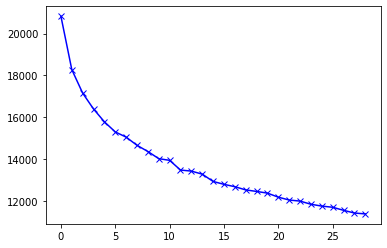

In [ ]:
n_clusters = 30               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1,n_clusters): # Пробегаем по списку от 1 до n_clusters
  kmean = KMeans(i)           # Создаем объект KMeans с i-классами
  kmean.fit(xTrain01Scaled)   # Проводим классетризацию xTrain01Scaled
  cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot(cost, 'bx-')
plt.show()

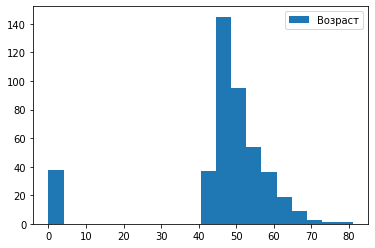

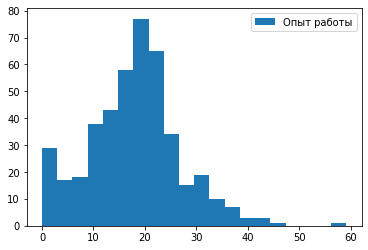

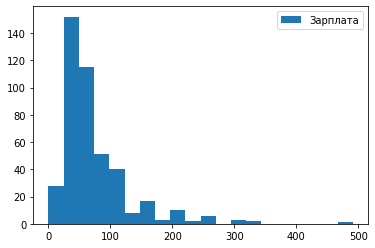

In [ ]:
clusterNumber = 6                           # Зададим номер кластера
cluster = yTrain[labels==clusterNumber,:]   # Получим из xTrain01 данные для указанного кластера
ages = cluster[:,0]                         # Получим все возраста в указанном кластере
exp = cluster[:,2] / 12                     # Получим все данные об опыте работы в указанном кластере
salary = cluster[:,1] / 1000                # Получим все данные о желаемой зарплате в указанном кластере

# Отобразим полученные данные на графиках
plt.hist(ages,20, label="Возраст")
plt.legend()
plt.show()
plt.hist(exp,20, label="Опыт работы")
plt.legend()
plt.show()
plt.hist(salary,20, label="Зарплата")
plt.legend()
plt.show()

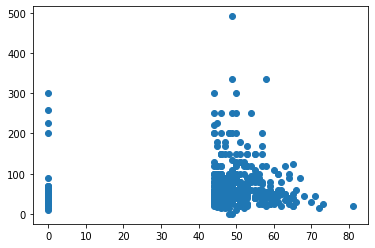

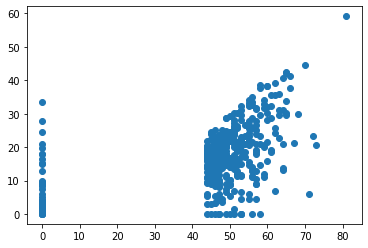

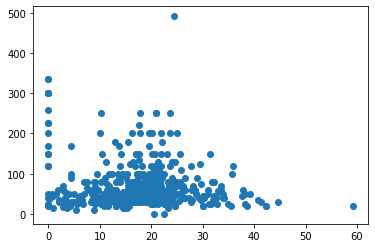

In [ ]:
plt.scatter(ages, salary)
plt.show()

plt.scatter(ages, exp)
plt.show()

plt.scatter(exp, salary)
plt.show()

###По специальности

In [ ]:
qty_clusters = 100            # Задаем количество кластеров
kmean = KMeans(qty_clusters) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(xTrainProf01)     # Произвдим кластеризацию данных xTrain01Scaled
labelsProf = kmean.labels_        # Получаем метки кластеров
print(labelsProf[:20])            # Выводим первые 20 меток

[44  9 88 59  8 58 55 27 58 32 26 30 75  2 81  6 81 10 86 61]


In [ ]:
# Функция определяет ключевые слова в кластере
def printProfCluster(x, bias, vocabulary):
  mask = np.mean(x, axis=0) > bias # Создаем маску для набора x, среднии значения которого больше bias
  mX = np.mean(x, axis=0)*100      # Получаем среднее значение для набора данных x
  words = ""                       # Создаем пустую строку
  
  for w in vocabulary:            # Проходим по всем элементам словаря
    index = vocabulary[w]         # Считываем значение очередного элемента
    if (index < mask.shape[0]):   # Если значение меньше размерности списка-маски
      if (mask[index]):           # Если в массиве-маске есть само значение
        val = round(mX[index])    # Получаем значение в процентах
        words += w + " " + str(val) + "%" + "\n" # Формируем строку вывода
  
  print(words)                    # Выводим все найденные слова

In [ ]:
clusterNumber =2                                                              # Указываем номер кластера
print("Размер кластера", sum(labelsProf==clusterNumber))                          # Выводим размер кластера
printProfCluster(xTrainProf01[labelsProf==clusterNumber,:], 0.5, vocabularyItems) # Получаем информацию по ключевым словам класетра

profs = xTrainTProf[labelsProf==clusterNumber]                                    # Получаем записи об указанном кластера
for p in profs:                                                                   # Выводим всю текстовую информацию в данном кластере
  print(p)

Размер кластера 78
специалист 100%
отдела 100%

Менеджер , руководителя отдела Ведущий специалист
Специалист в IT отдел Специалист отдела сопровождения бэк-офисных систем
Руководитель отдела/группы, архитектор, ведущий специалист 2018 старший консультант
Менеджер проектов Ведущий специалист отдела бэк-офис продаж, группа сопровождения процессов по финансовым услугам
Менеджер Специалист абонентского отдела
Ведущий специалист отдела внедрения и сопровождения Старший специалист процессингого центра
Ведущий специалист отдела сопровождения Ведущий менеджер-операционист
Специалист отдела контроля качества Специалист контроля качества контактного центра
Ведущий инженер связи Гл. специалист отдела ЭТО
Специалист отдела маркетинга и развития бизнеса Руководитель отдела маркетига
Технический специалист Инженер отдела технического сопровождения
Младший специалист технического отдела Прессовщик
Специалист по IT Ведущий специалист IT отдела
Менеджер, ведущий специалист Ведущий специалист отдела
Спе

In [ ]:
for clusterNumber in range(100):                                                    # Пробегаем в цикле от 0 до 100 
  print("Номер кластера", clusterNumber)
  print("Размер кластера", sum(labelsProf==clusterNumber))                          # Печатаем размер очередного кластера
  printProfCluster(xTrainProf01[labelsProf==clusterNumber,:], 0.5, vocabularyItems) # Получаем информацию по ключевым словам очередного кластера
  print()
  print()

Номер кластера 0
Размер кластера 1
по 100%
руководитель 100%
проектов 100%
с 100%
работе 100%
заместитель 100%
директора 100%
развитию 100%
бизнеса 100%
ключевыми 100%
служба 100%
заказчиками 100%
ключевых 100%
заказчика 100%



Номер кластера 1
Размер кластера 111
менеджер 100%



Номер кластера 2
Размер кластера 78
специалист 100%
отдела 100%



Номер кластера 3
Размер кластера 130
инженер 100%
администратор 92%
системный 98%



Номер кластера 4
Размер кластера 45
руководитель 89%
отдела 89%
поддержки 51%



Номер кластера 5
Размер кластера 128
специалист 100%



Номер кластера 6
Размер кластера 143
оператор 100%



Номер кластера 7
Размер кластера 36
руководитель 100%



Номер кластера 8
Размер кластера 29
инженер 100%
специалист 100%
программист 76%



Номер кластера 9
Размер кластера 24
по 96%
консультант 100%



Номер кластера 10
Размер кластера 69
монтажник 91%
систем 100%
слаботочных 100%



Номер кластера 11
Размер кластера 144
по 100%
менеджер 77%
с 99%
работе 100%
клиентами 

Разбиение на 10 кластеров готово
Разбиение на 20 кластеров готово
Разбиение на 30 кластеров готово
Разбиение на 40 кластеров готово
Разбиение на 50 кластеров готово
Разбиение на 60 кластеров готово
Разбиение на 70 кластеров готово
Разбиение на 80 кластеров готово
Разбиение на 90 кластеров готово
Разбиение на 100 кластеров готово
Разбиение на 110 кластеров готово
Разбиение на 120 кластеров готово
Разбиение на 130 кластеров готово
Разбиение на 140 кластеров готово
Разбиение на 150 кластеров готово
Разбиение на 160 кластеров готово
Разбиение на 170 кластеров готово
Разбиение на 180 кластеров готово
Разбиение на 190 кластеров готово
Время обработки:  3867.54 c


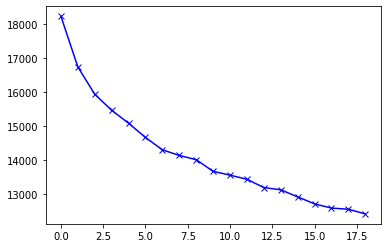

In [ ]:
cur_time = time.time()
# Отобразим график разбияния на различное количество классов
cost = []
for i in range(1,20):
  print("Разбиение на ", i*10, " кластеров готово", sep="")
  kmean = KMeans(i*10)
  kmean.fit(xTrainProf01)
  cost.append(kmean.inertia_)
    
plt.plot(cost, 'bx-')
print('Время обработки: ', round(time.time()-cur_time,2),'c');

#Prediction of a new element

In [ ]:
xTrainProf01[15]

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
print(kmean.predict([xTrainProf01[15]])) # Определяем к какому кластеру относиться элемент

[6]


In [ ]:
xTrainTProf[15]                          # Отобразим рассматриваемый элемент

'Оператор ПК Инженер-проектировщик ОВИК'

#Иерархическая кластеризация

In [ ]:
from sklearn.cluster import AgglomerativeClustering                                     # Импортируем модуль иерархической кластирезации

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  # Создаем объект AgglomerativeClustering
cluster.fit_predict(xTrain01Scaled)                                                     # Производим класстеризацию набора xTrain01Scaled
labels = cluster.labels_ # Получаем список меток
print(labels[:20])       # Выводим первые 20 меток

[7 2 4 6 3 8 0 3 0 6 2 1 4 3 8 6 1 5 1 4]


In [ ]:
clusterNumber = 1                               # Укажем номер кластера
printCluster(xTrain01Scaled[labels==clusterNumber,:], yTrain[labels==clusterNumber,:]) # Выведем информацию о кластере с указанным номером
print('\n\nПрофессии: \n', xTrainTProf[labels==clusterNumber])

Размер кластера: 814
Пол: 74% мужчины
Возраст: 37, разброс: 10.4
Зарплата: 63159, разброс: 55540.0
Опыт работы: 9.7, разброс: 6.6

Возраст_разбивка
Возраст   <19: 5%
Возраст 19-23: 1%
Возраст 24-28: 10%
Возраст 29-33: 8%
Возраст 34-38: 29%
Возраст 39-43: 26%
Возраст 44-48: 13%
Возраст 49-53: 7%
Возраст 54-58: 0%
Возраст 59-63: 0%
Возраст   64+: 0%

Территориально
Москва: 2%
Санкт-Петербург: 2%
Города миллионники: 3%
Другие города: 93%

Тип занятости
Стажировка: 1%
Частичная занятость: 7%
Проектная работа: 3%
Полная занятость: 100%

График
Гибкий график: 9%
Полный день: 98%
Сменный график: 10%
Удаленная работа: 10%

Образование
Высшее: 93%
Среднее специальное: 4%
Неоконченное высшее: 1%
Среднее образование: 2%

Опыт работы разбивка
До полугода: 13%
От полугода до 1 года: 3%
От 1 до 2 лет: 3%
От 2 до 3 лет: 3%
От 3 до 5 лет: 6%
От 5 до 8 лет: 8%
От 8 до 10 лет: 15%
От 10 до 13 лет: 17%
От 13 до 16 лет: 15%
От 16 до 20 лет: 10%
Более 20 лет: 6%


Профессии: 
 ['Технический специалист Руко

#Задание по кластеризации слов в Embedding-пространстве.

In [ ]:
print(xTrainTProf.shape)
xTrainTProf

(4912,)


array(['Специалист по поддержке пользователей Медицинская сестра палатная',
       'Аналитик-консультант 1С Специалист по планированию производства',
       'Электромонтер связи Инженер', ...,
       'Системный администратор Системный администратор',
       'Программист Продавец-консультант',
       'Системный администратор Системный администратор'], dtype='<U244')

In [ ]:
maxWordsCount = 2766 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTProf)         # "Скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра
print("Размер словаря", len(items)) # Длина словаря
items[:10]

Размер словаря 2765


[('unknown', 1),
 ('инженер', 2),
 ('специалист', 3),
 ('по', 4),
 ('менеджер', 5),
 ('администратор', 6),
 ('системный', 7),
 ('руководитель', 8),
 ('отдела', 9),
 ('программист', 10)]

In [ ]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Уточните слово: аналитик
Интересующее слово имеет индекс:  22


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #Обучающие тексты в индексы
xTrainProfIndexes[:10]

[[3, 4, 120, 118, 581, 582, 1167],
 [22, 34, 38, 3, 4, 282, 248],
 [141, 36, 2],
 [5, 23, 45, 1168],
 [27, 3, 2, 10],
 [8, 18, 8, 18],
 [5, 13, 11, 22, 8, 14, 9, 5, 307],
 [2, 3, 4, 1169, 583, 36],
 [8, 18, 2, 211, 29, 2],
 [10, 127, 2]]

In [ ]:
print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", xTrainTProf[1][:100])
print("Он же в виде последовательности индексов: ", xTrainProfIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Аналитик-консультант 1С Специалист по планированию производства
Он же в виде последовательности индексов:  [22, 34, 38, 3, 4, 282, 248] 



In [ ]:
xTrainProfIndexes=np.array(xTrainProfIndexes)
yTrainSal=np.array(yTrain[:,1]/1000)
xTrainE, xValE, yTrainE, yValE = train_test_split(xTrainProfIndexes, yTrainSal, test_size=0.1)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrainE.shape)  #и на форму соответствующих им классов
print(xValE.shape)
print(yValE.shape)

(4420,)
(4420,)
(492,)
(492,)


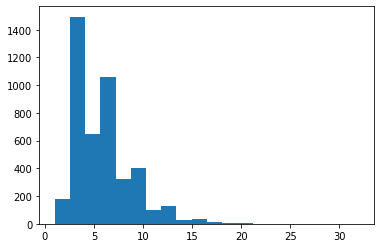

In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 20)
plt.show()

In [ ]:
maxlen = 15
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы
print(xTrainE.shape)
print(xValE.shape)

(4420, 15)
(492, 15)


### Embedding-пространство 70, 10 кластеров.

In [ ]:
#Создаём полносвязную сеть
modelE = Sequential()
#Cлой представления всего словаря слов в векторном представлении
modelE.add(Embedding(maxWordsCount, 70, input_length=maxlen))
#Слой регуляризации Dropout
modelE.add(SpatialDropout1D(0.3))
#Cлой преобразования двумерных данных в одномерные
modelE.add(Flatten())
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Полносвязный слой
modelE.add(Dense(864, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.3))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
modelE.add(Dense(664, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.3))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
modelE.add(Dense(464, activation="relu"))
#Слой регуляризации Dropout
modelE.add(Dropout(0.3))
#Слой пакетной нормализации
modelE.add(BatchNormalization())
#Выходной полносвязный слой
modelE.add(Dense(1, activation='relu'))

modelE.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mae')

#Обучаем сеть на xTrain
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=20,
                    validation_data=(xValE, yValE))

Epoch 1/15
221/221 [==============================] - 3s 9ms/step - loss: 46.5139 - val_loss: 32.8339
Epoch 2/15
221/221 [==============================] - 2s 8ms/step - loss: 35.5518 - val_loss: 29.9805
Epoch 3/15
221/221 [==============================] - 2s 8ms/step - loss: 31.1732 - val_loss: 28.0507
Epoch 4/15
221/221 [==============================] - 2s 9ms/step - loss: 28.7850 - val_loss: 27.8835
Epoch 5/15
221/221 [==============================] - 2s 8ms/step - loss: 27.1179 - val_loss: 27.3090
Epoch 6/15
221/221 [==============================] - 2s 9ms/step - loss: 25.0591 - val_loss: 27.4460
Epoch 7/15
221/221 [==============================] - 2s 8ms/step - loss: 23.9132 - val_loss: 28.0620
Epoch 8/15
221/221 [==============================] - 2s 9ms/step - loss: 23.2811 - val_loss: 28.2567
Epoch 9/15
221/221 [==============================] - 2s 9ms/step - loss: 22.8932 - val_loss: 27.7472
Epoch 10/15
221/221 [==============================] - 2s 8ms/step - loss: 22.2441

In [ ]:
modelE.save_weights('/content/drive/MyDrive/Colab Notebooks/15. Алгоритмы кластеризации данных/modelEmbedding.h5')

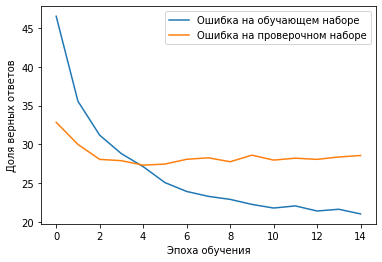

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
embeddings = Embedding.get_weights(modelE)[0] #or modelE.layers[0].get_weights()[0]
print(embeddings.shape)
print(len(items))

(2766, 70)
2765


In [ ]:
words_dic=[]
words_embeddings=[]
for w, idx in items:
  words_dic.append(w)
  words_embeddings.append(embeddings[idx])
words_dic=np.array(words_dic)
words_embeddings=np.array(words_embeddings)
print(words_dic.shape)
print(words_embeddings.shape)

(2765,)
(2765, 70)


In [ ]:
qty_clusters = 10            # Задаем количество кластеров
kmean = KMeans(qty_clusters) 
kmean.fit(words_embeddings)    
labels = kmean.labels_        # Получаем метки кластеров
print(labels[:20])            # Выводим первые 20 меток

[5 2 8 2 2 8 1 0 5 5 0 5 0 5 2 2 8 5 0 9]


In [ ]:
for clusterNumber in range(qty_clusters):
  print("Cluster#: ", clusterNumber)
  print("Cluster size: ", len(list(words_dic[labels==clusterNumber])))
  print('\n')
  print(words_dic[labels==clusterNumber][:30])
  print('\n')

Cluster#:  0
Cluster size:  187


['руководитель' 'ведущий' 'проектов' 'начальник' 'директор' 'старший' 'ит'
 'главный' 'развитию' 'разработки' 'c' 'архитектор' 'сетевой' 'product'
 'баз' 'проектами' 'business' 'python' 'ios' 'администрирования' 'analyst'
 'and' 'data' 'ключевыми' 'js' 'ux' 'рекламы' 'инфраструктуры' 'system'
 'компании']


Cluster#:  1
Cluster size:  519


['системный' 'монтажник' 'продажам' 'web' 'контент' 'сервисный' 'центра'
 'региональный' 'электрик' 'категории' 'асу' 'frontend' 'информационным'
 'технического' 'верстальщик' 'qa' 'пользователей' 'html' 'представитель'
 'проектировщик' 'обслуживания' 'designer' 'software' 'работа' 'отдел'
 'торговый' 'информационно' 'ассистент' 'работ' 'мониторинга']


Cluster#:  2
Cluster size:  422


['инженер' 'по' 'менеджер' 'технической' 'и' 'интернет' 'с' 'работе'
 'систем' 'консультант' 'связи' 'информационных' 'дизайнер' 'магазина'
 'слаботочных' 'системного' 'службы' 'маркетолог' 'продаж' 'директора'
 'руководителя' 'инфор

##Embedding-пространство 50, 5 кластеров.

In [ ]:
modelE50_5 = Sequential()
modelE50_5.add(Embedding(maxWordsCount, 50, input_length=maxlen))
modelE50_5.add(SpatialDropout1D(0.3))
modelE50_5.add(Flatten())
modelE50_5.add(BatchNormalization())
modelE50_5.add(Dense(864, activation="relu"))
modelE50_5.add(Dropout(0.3))
modelE50_5.add(BatchNormalization())
modelE50_5.add(Dense(664, activation="relu"))
modelE50_5.add(Dropout(0.3))
modelE50_5.add(BatchNormalization())
modelE50_5.add(Dense(464, activation="relu"))
modelE50_5.add(Dropout(0.3))
modelE50_5.add(BatchNormalization())
modelE50_5.add(Dense(1, activation='relu'))

modelE50_5.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mae')

#Обучаем сеть на xTrain
history = modelE50_5.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=20,
                    validation_data=(xValE, yValE))

Epoch 1/15
221/221 [==============================] - 5s 11ms/step - loss: 46.8303 - val_loss: 35.2846
Epoch 2/15
221/221 [==============================] - 2s 10ms/step - loss: 34.5604 - val_loss: 29.7417
Epoch 3/15
221/221 [==============================] - 2s 9ms/step - loss: 29.6263 - val_loss: 27.2849
Epoch 4/15
221/221 [==============================] - 2s 8ms/step - loss: 28.2383 - val_loss: 26.8664
Epoch 5/15
221/221 [==============================] - 2s 9ms/step - loss: 26.6903 - val_loss: 27.7591
Epoch 6/15
221/221 [==============================] - 2s 8ms/step - loss: 25.1234 - val_loss: 27.3768
Epoch 7/15
221/221 [==============================] - 2s 8ms/step - loss: 24.2559 - val_loss: 27.3017
Epoch 8/15
221/221 [==============================] - 2s 9ms/step - loss: 23.1844 - val_loss: 27.2948
Epoch 9/15
221/221 [==============================] - 2s 9ms/step - loss: 22.5397 - val_loss: 27.7765
Epoch 10/15
221/221 [==============================] - 2s 9ms/step - loss: 22.74

In [ ]:
embeddings = Embedding.get_weights(modelE50_5)[0]
print(embeddings.shape)
print(len(items))

(2766, 50)
2765


In [ ]:
words_dic=[]
words_embeddings=[]
for w, idx in items:
  words_dic.append(w)
  words_embeddings.append(embeddings[idx])
words_dic=np.array(words_dic)
words_embeddings=np.array(words_embeddings)
print(words_dic.shape)
print(words_embeddings.shape)

(2765,)
(2765, 50)


In [ ]:
qty_clusters = 5            # Задаем количество кластеров
kmean = KMeans(qty_clusters) 
kmean.fit(words_embeddings)    
labels = kmean.labels_        # Получаем метки кластеров
print(labels[:20])            # Выводим первые 20 меток

[3 3 0 3 3 0 3 4 3 3 4 0 4 3 0 3 0 4 4 4]


In [ ]:
for clusterNumber in range(qty_clusters):
  print("Cluster#: ", clusterNumber)
  print("Cluster size: ", len(list(words_dic[labels==clusterNumber])))
  print('\n')
  print(words_dic[labels==clusterNumber][:30])
  print('\n')

Cluster#:  0
Cluster size:  529


['специалист' 'администратор' 'поддержки' 'технической' 'оператор'
 'монтажник' 'помощник' 'техник' 'связи' 'клиентами' 'web' 'контент'
 'мастер' 'системного' 'администратора' 'веб' 'ремонту' 'в' 'региональный'
 'тестировщик' 'пк' 'сайта' 'безопасности' 'электрик' 'сети' 'junior'
 'информации' 'сопровождения' 'младший' 'эксплуатации']


Cluster#:  1
Cluster size:  373


['продажам' 'продавец' 'центра' 'обслуживанию' 'координатор' 'слесарь'
 'кассир' 'qa' 'пользователей' 'автоматизации' 'видеонаблюдения'
 'подразделения' 'обслуживания' 'электромеханик' 'копирайтер' 'секретарь'
 'сайтов' 'backend' 'качества' 'системотехник' 'диспетчер' 'строительству'
 'бухгалтер' 'асессор' 'учитель' 'фрилансер' 'ui' 'магазином'
 'информатики' 'аудиозаписей']


Cluster#:  2
Cluster size:  311


['аналитик' '1с' 'технологий' 'developer' 'начальника' 'engineer' 'бизнес'
 'project' 'php' 'оборудования' 'технологиям' 'внедрению' 'внедрения'
 'генеральный' 'проектами' 'маркет

##Embedding-пространство 20, 20 кластеров.

In [ ]:
modelE20_20 = Sequential()
modelE20_20.add(Embedding(maxWordsCount, 20, input_length=maxlen))
modelE20_20.add(SpatialDropout1D(0.3))
modelE20_20.add(Flatten())
modelE20_20.add(BatchNormalization())
modelE20_20.add(Dense(864, activation="relu"))
modelE20_20.add(Dropout(0.3))
modelE20_20.add(BatchNormalization())
modelE20_20.add(Dense(664, activation="relu"))
modelE20_20.add(Dropout(0.3))
modelE20_20.add(BatchNormalization())
modelE20_20.add(Dense(464, activation="relu"))
modelE20_20.add(Dropout(0.3))
modelE20_20.add(BatchNormalization())
modelE20_20.add(Dense(1, activation='relu'))

modelE20_20.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mae')

#Обучаем сеть на xTrain
history = modelE20_20.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=20,
                    validation_data=(xValE, yValE))

Epoch 1/15
221/221 [==============================] - 3s 9ms/step - loss: 47.4443 - val_loss: 32.8418
Epoch 2/15
221/221 [==============================] - 2s 8ms/step - loss: 35.3921 - val_loss: 32.1413
Epoch 3/15
221/221 [==============================] - 2s 8ms/step - loss: 30.7027 - val_loss: 27.2451
Epoch 4/15
221/221 [==============================] - 2s 7ms/step - loss: 28.9012 - val_loss: 28.7121
Epoch 5/15
221/221 [==============================] - 2s 7ms/step - loss: 26.9234 - val_loss: 27.2354
Epoch 6/15
221/221 [==============================] - 2s 7ms/step - loss: 25.1469 - val_loss: 27.2896
Epoch 7/15
221/221 [==============================] - 2s 7ms/step - loss: 24.1870 - val_loss: 27.1250
Epoch 8/15
221/221 [==============================] - 2s 7ms/step - loss: 23.8522 - val_loss: 28.1964
Epoch 9/15
221/221 [==============================] - 2s 7ms/step - loss: 23.3550 - val_loss: 27.3755
Epoch 10/15
221/221 [==============================] - 2s 8ms/step - loss: 23.2701

In [ ]:
embeddings = Embedding.get_weights(modelE20_20)[0]
print(embeddings.shape)
print(len(items))

(2766, 20)
2765


In [ ]:
words_dic=[]
words_embeddings=[]
for w, idx in items:
  words_dic.append(w)
  words_embeddings.append(embeddings[idx])
words_dic=np.array(words_dic)
words_embeddings=np.array(words_embeddings)
print(words_dic.shape)
print(words_embeddings.shape)

(2765,)
(2765, 20)


In [ ]:
qty_clusters = 20            # Задаем количество кластеров
kmean = KMeans(qty_clusters) 
kmean.fit(words_embeddings)    
labels = kmean.labels_        # Получаем метки кластеров
print(labels[:20])            # Выводим первые 20 меток

[ 2  3 11  4  4  4  3  9  3  1  7  3  9 15  4  2  8 15 19 19]


In [ ]:
for clusterNumber in range(qty_clusters):
  print("Cluster#: ", clusterNumber)
  print("Cluster size: ", len(list(words_dic[labels==clusterNumber])))
  print('\n')
  print(words_dic[labels==clusterNumber][:30])
  print('\n')

Cluster#:  0
Cluster size:  175


['интернет' 'информационных' 'web' 'асу' 'редактор' '1' 'клиентов' 'java'
 'электроник' 'подразделения' 'представитель' 'копирайтер' 'отдел'
 'торговый' 'ассистент' 'закупкам' 'исполнительный' 'приложений'
 'department' 'автор' 'логистике' 'телекоммуникаций' 'управление'
 'общественностью' 'работы' 'гейм' 'таргетолог' 'сварщик' 'класса'
 'делопроизводитель']


Cluster#:  1
Cluster size:  103


['программист' 'seo' 'sap' 'внедрению' 'департамента' 'маркетингу'
 'конструктор' 'зам' 'средств' 'моделлер' '3' 'рекламы' 'партнерами'
 'прораб' 'фриланс' 'смены' 'технических' 'испытатель' 'кафедры'
 'ремонтник' 'интеграции' 'оит' 'скс' 'учета' 'разработке' 'каналов'
 'занятость' 'планирования' 'разряд' 'закупок']


Cluster#:  2
Cluster size:  276


['unknown' 'и' 'клиентами' 'группы' 'сервисный' 'категории' 'руководителя'
 'frontend' 'project' 'пользователей' 'проектировщик' 'процессов' 'кипиа'
 'участка' 'мониторинга' 'экспедитор' 'корпоративными' 'specialist

#Conclusion

Большее embedding-пространство предоставляет больше переменных для кластеризации, что скорее увеличивает точность кластеризации. Кол-во кластеров независимо от величины embedding-пространства скорее нужно подбирать при помощи показателей inertia_ для нахождения оптимального кол-ва. Одновременно увеличение embedding-пространства не должно уменьшать эффективность обучения сети.